# The primary dataset generation
This notebook we will create datasets that can be used to feature selection. The major procedure includes filling out the missing values, drop the features that majority of them are missing, do the log transform for the numerical features, generate the interaction features. For categorical features, there are two different approaches, one is the regular [One Hot Encoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), the other approach is [Empirical Bayesian Method](http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.pdf). We can generate three different ways to generate the dataset. After all the procedure, we will do the standardization to get mearn 0 and standard deviation of 1.  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')
import warnings
import json
import pickle
from sklearn.preprocessing import Imputer
warnings.filterwarnings('ignore')

In [2]:
training = "../../data/train.csv"
test = "../../data/test.csv"
modified = "../../data/modified/"

In [3]:
df_train = pd.read_csv(training)
df_test = pd.read_csv(test)

## Outliers
Those data `with more than 4000 square feet` can be considered as outlier according to the [paper](https://ww2.amstat.org/publications/jse/v19n3/decock.pdf). We can remove them in the training data at first.

In [4]:
df_train = df_train[df_train.GrLivArea < 4000]

## Missing values
We can drop some features that most of which are missing values, which doesn't contribute much to our target value -- housing price.

In [5]:
drop_missing = ["PoolQC", "MiscFeature", "Alley", "Fence"]

In [6]:
df_train.drop(drop_missing, inplace=True, axis=1)
df_test.drop(drop_missing, inplace=True, axis=1)

In [7]:
def fill_specific(data, spec):
    col = []
    for key, val in spec.items():
        if isinstance(val, list):
            for item in val:
                if item in data.columns.values:
                    data[item].fillna(key, inplace=True)
                    print("Column {0} 's empty value has been replaced by {1}".format(item, key))
                    col.append(item)
                else:
                    print("{0} is not a column in the dataset.".format(item))
        else:
            print("To replace NA values with {0}, a list needs to be specified.".format(key))
    print("\n Now the columns have been updated:")
    print(col)

In [8]:
fill_dict = {"NoBsmt": ["BsmtFinType1", "BsmtCond", "BsmtFinType2", "BsmtExposure", "BsmtQual"],
             "NoGarage": ["GarageCond", "GarageQual", "GarageFinish", "GarageType"],
             "NoPool": ["PoolQC"],
             "NoFirePlace": ["FireplaceQu"],
             "NoFence":["Fence"],
             "NoAccess": ["Alley"],
             "None": ["MiscFeature", "MasVnrType"]
             }

In [9]:
fill_specific(df_train,fill_dict)

MiscFeature is not a column in the dataset.
Column MasVnrType 's empty value has been replaced by None
Alley is not a column in the dataset.
PoolQC is not a column in the dataset.
Column FireplaceQu 's empty value has been replaced by NoFirePlace
Column BsmtFinType1 's empty value has been replaced by NoBsmt
Column BsmtCond 's empty value has been replaced by NoBsmt
Column BsmtFinType2 's empty value has been replaced by NoBsmt
Column BsmtExposure 's empty value has been replaced by NoBsmt
Column BsmtQual 's empty value has been replaced by NoBsmt
Column GarageCond 's empty value has been replaced by NoGarage
Column GarageQual 's empty value has been replaced by NoGarage
Column GarageFinish 's empty value has been replaced by NoGarage
Column GarageType 's empty value has been replaced by NoGarage
Fence is not a column in the dataset.

 Now the columns have been updated:
['MasVnrType', 'FireplaceQu', 'BsmtFinType1', 'BsmtCond', 'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'GarageCond', '

In [10]:
fill_specific(df_test, fill_dict)

MiscFeature is not a column in the dataset.
Column MasVnrType 's empty value has been replaced by None
Alley is not a column in the dataset.
PoolQC is not a column in the dataset.
Column FireplaceQu 's empty value has been replaced by NoFirePlace
Column BsmtFinType1 's empty value has been replaced by NoBsmt
Column BsmtCond 's empty value has been replaced by NoBsmt
Column BsmtFinType2 's empty value has been replaced by NoBsmt
Column BsmtExposure 's empty value has been replaced by NoBsmt
Column BsmtQual 's empty value has been replaced by NoBsmt
Column GarageCond 's empty value has been replaced by NoGarage
Column GarageQual 's empty value has been replaced by NoGarage
Column GarageFinish 's empty value has been replaced by NoGarage
Column GarageType 's empty value has been replaced by NoGarage
Fence is not a column in the dataset.

 Now the columns have been updated:
['MasVnrType', 'FireplaceQu', 'BsmtFinType1', 'BsmtCond', 'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'GarageCond', '

In [11]:
def calculate_empty(input_data, value=0):
    """
    Find the all the columns with empty values with descending order, where the number of the empty values is larger
    than value
    :param input_data: the input data as a Pandas DataFrame
    :param value: the minimum number of the empty values in the column
    :return: A Pandas Series having empty values with column name and number of empty values
    """
    if not isinstance(input_data, pd.DataFrame):
        raise TypeError("Input data is not a valid Pandas DataFrame")
    columns = input_data.isnull().sum()
    columns = columns[columns > value]
    columns.sort_values(ascending=False, inplace=True)
    return columns

In [12]:
def current_empty(input_data):
    """
    Compute the list of the column names with empty values
    :param input_data: the input data as a Pandas DataFrame
    :return: A list of the column names with empty values
    """
    cols = list(calculate_empty(input_data).index)
    if cols:
        print("Now the column name(s) that have empty values are:")
        print(calculate_empty(input_data))
    else:
        print("There are no empty values in the data.")
    return cols

In [13]:
current_empty(df_train)

Now the column name(s) that have empty values are:
LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
Electrical       1
dtype: int64


['LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'Electrical']

In [14]:
current_empty(df_test)

Now the column name(s) that have empty values are:
LotFrontage     227
GarageYrBlt      78
MasVnrArea       15
MSZoning          4
Functional        2
Utilities         2
BsmtHalfBath      2
BsmtFullBath      2
BsmtFinSF1        1
Exterior1st       1
Exterior2nd       1
SaleType          1
BsmtFinSF2        1
GarageArea        1
TotalBsmtSF       1
KitchenQual       1
GarageCars        1
BsmtUnfSF         1
dtype: int64


['LotFrontage',
 'GarageYrBlt',
 'MasVnrArea',
 'MSZoning',
 'Functional',
 'Utilities',
 'BsmtHalfBath',
 'BsmtFullBath',
 'BsmtFinSF1',
 'Exterior1st',
 'Exterior2nd',
 'SaleType',
 'BsmtFinSF2',
 'GarageArea',
 'TotalBsmtSF',
 'KitchenQual',
 'GarageCars',
 'BsmtUnfSF']

### Garage features
There is one mising value in `GarageArea` and `GarageCars` in the test data. We can have a look at the garage type in this case.

In [15]:
Garagetype = df_test.loc[df_test.GarageArea.isnull(),'GarageType']
print ("The GarageType is " + Garagetype.values[0] +
       ", when the Garage Area is empty.")

The GarageType is Detchd, when the Garage Area is empty.


We can replace the missing value with the median value of `GarageArea` and `GarageCars` when the `GarageType` is `Detchd`. 

In [16]:
def fill_group(data, group):
    """
    This function will go through the dictionary of group, for each column as key[0] has a value of key[1], it will
    fill those columns' empty values in the corresponding list as the mode of the group in column key[0] with value
    key[1] if it is category, or median of the group in column key[0] with value key[1] if it is a numeric one.
    :param group: A dictionary has the key as the tuple of (col1, val1) and value as a list
    :return:
    """
    if not isinstance(group, dict):
        raise TypeError("A dictionary needs to be passed to specify how to fill empty values with group")

    col = []
    value = 0
    for key, val in group.items():
        if key[0] in data.columns.values:
            if isinstance(val, list):
                for item in val:
                    if item in data.columns.values:
                        if data[item].dtypes == "object":
                            value = data.loc[data[key[0]] == key[1], item].mode()[0]
                        else:
                            value = data.loc[data[key[0]] == key[1], item].median()
                        data[item].fillna(value, inplace=True)
                        print("Now column {0} 's empty value has been replaced by {1}".format(item, value))
                        col.append(item)

            else:
                print("To replace {0}, a list needs to be specified.".format(key[1]))

        else:
            print("{0} is not a column in the dataset.".format(key[0]))
    print("\n Now the columns have been updated:")
    print(col)

In [17]:
group = {("GarageType", "Detchd"): ["GarageArea", "GarageCars"] }

In [18]:
fill_group(df_test,group)

Now column GarageArea 's empty value has been replaced by 384.0
Now column GarageCars 's empty value has been replaced by 1.0

 Now the columns have been updated:
['GarageArea', 'GarageCars']


In [19]:
current_empty(df_test)

Now the column name(s) that have empty values are:
LotFrontage     227
GarageYrBlt      78
MasVnrArea       15
MSZoning          4
Functional        2
BsmtHalfBath      2
BsmtFullBath      2
Utilities         2
SaleType          1
KitchenQual       1
TotalBsmtSF       1
BsmtUnfSF         1
BsmtFinSF2        1
BsmtFinSF1        1
Exterior2nd       1
Exterior1st       1
dtype: int64


['LotFrontage',
 'GarageYrBlt',
 'MasVnrArea',
 'MSZoning',
 'Functional',
 'BsmtHalfBath',
 'BsmtFullBath',
 'Utilities',
 'SaleType',
 'KitchenQual',
 'TotalBsmtSF',
 'BsmtUnfSF',
 'BsmtFinSF2',
 'BsmtFinSF1',
 'Exterior2nd',
 'Exterior1st']

In [20]:
def convert_value(data, matching):
    if not isinstance(matching, dict):
        raise TypeError("A dictionary needs to be passed to convert the columns.")

    col = []
    for key, val in matching.items():
        if isinstance(val, list):
            for item in val:
                if item[0] in data.columns.values and item[1] in data.columns.values:
                    data.loc[data[item[0]] == key[0], item[1]] = key[1]
                    col.append(item[1])
                else:
                    print("Please check the column names, {0} or {1} may not be a valid column name".format(item[0],item[1]))
        else:
            print("The columns to convert need to be a list.")
    print("\n Now the columns have been updated:")
    print(col)

In [21]:
value_matching = {
    ("NoBsmt", 0): [("BsmtFinType1", "BsmtFinSF1"), ("BsmtFinType2", "BsmtFinSF2"), ("BsmtQual", "TotalBsmtSF"),
                    ("BsmtQual", "BsmtUnfSF")
                    ],
    ("None", 0):[("MasVnrType","MasVnrArea")],
    ("NoGarage", 0) : [("GarageType", "GarageCars"), ("GarageType", "GarageArea")],
    ("NoFirePlace", 0): [("FireplaceQu", "Fireplaces")]
}

In [22]:
convert_value(df_train, value_matching)


 Now the columns have been updated:
['MasVnrArea', 'GarageCars', 'GarageArea', 'Fireplaces', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtUnfSF']


In [23]:
current_empty(df_train)

Now the column name(s) that have empty values are:
LotFrontage    259
GarageYrBlt     81
Electrical       1
dtype: int64


['LotFrontage', 'GarageYrBlt', 'Electrical']

In [24]:
convert_value(df_test, value_matching)


 Now the columns have been updated:
['MasVnrArea', 'GarageCars', 'GarageArea', 'Fireplaces', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtUnfSF']


In [25]:
current_empty(df_test)

Now the column name(s) that have empty values are:
LotFrontage     227
GarageYrBlt      78
MSZoning          4
Functional        2
BsmtHalfBath      2
BsmtFullBath      2
Utilities         2
SaleType          1
KitchenQual       1
Exterior2nd       1
Exterior1st       1
dtype: int64


['LotFrontage',
 'GarageYrBlt',
 'MSZoning',
 'Functional',
 'BsmtHalfBath',
 'BsmtFullBath',
 'Utilities',
 'SaleType',
 'KitchenQual',
 'Exterior2nd',
 'Exterior1st']

### Garage Year Built
2216 of the 2919 houses have same year for for `GarageYrBlt` and `YearBuilt`.Replace any of the NA’s for `GarageYrBlt` with the year from `YearBuilt`.

In [26]:
df_train['GarageYrBlt'].fillna(df_train['YearBuilt'], inplace=True)

In [27]:
current_empty(df_train)

Now the column name(s) that have empty values are:
LotFrontage    259
Electrical       1
dtype: int64


['LotFrontage', 'Electrical']

In [28]:
df_test['GarageYrBlt'].fillna(df_test['YearBuilt'], inplace=True)
current_empty(df_test)

Now the column name(s) that have empty values are:
LotFrontage     227
MSZoning          4
Functional        2
BsmtHalfBath      2
BsmtFullBath      2
Utilities         2
SaleType          1
KitchenQual       1
Exterior2nd       1
Exterior1st       1
dtype: int64


['LotFrontage',
 'MSZoning',
 'Functional',
 'BsmtHalfBath',
 'BsmtFullBath',
 'Utilities',
 'SaleType',
 'KitchenQual',
 'Exterior2nd',
 'Exterior1st']

### LotFrontage
`LotFrontage` is the linear feet of street connected to property. We can explore its relations with `LotArea`.

In [29]:
df_train['LotFrontage'].corr(df_train['LotArea'])

0.38757021208207809

In [30]:
df_test['LotFrontage'].corr(df_test['LotArea'])

0.6446084977757518

Let's find the relation between `LotFrontage` and  the root square of `LotArea`.

In [31]:
df_test['LotFrontage'].corr(np.sqrt(df_test['LotArea']))

0.70300193477713013

In [32]:
df_train['LotFrontage'].corr(np.sqrt(df_train['LotArea']))

0.58015981105630132

We can fill the missing values of `LotFrontage` with the square root of `LotArea`.

In [33]:
df_train['LotFrontage'].fillna(np.sqrt(df_train['LotArea']), inplace=True)
df_test['LotFrontage'].fillna(np.sqrt(df_test['LotArea']), inplace=True)

In [34]:
current_empty(df_train)

Now the column name(s) that have empty values are:
Electrical    1
dtype: int64


['Electrical']

In [35]:
current_empty(df_test)

Now the column name(s) that have empty values are:
MSZoning        4
Functional      2
BsmtHalfBath    2
BsmtFullBath    2
Utilities       2
SaleType        1
KitchenQual     1
Exterior2nd     1
Exterior1st     1
dtype: int64


['MSZoning',
 'Functional',
 'BsmtHalfBath',
 'BsmtFullBath',
 'Utilities',
 'SaleType',
 'KitchenQual',
 'Exterior2nd',
 'Exterior1st']

In [36]:
df_train['Electrical'].fillna(df_train['Electrical'].value_counts().idxmax(), inplace=True)

In [37]:
current_empty(df_train)

There are no empty values in the data.


[]

In [38]:
placement = ['MSZoning','Functional','Utilities','SaleType','KitchenQual','Exterior2nd','Exterior1st']
for feature in placement:
    df_test[feature].fillna(df_train[feature].value_counts().idxmax(),inplace=True)

In [39]:
medians = ['BsmtHalfBath','BsmtFullBath' ]
for feature in medians:
    df_test[feature].fillna(df_train[feature].median(), inplace=True)

In [40]:
current_empty(df_test)

There are no empty values in the data.


[]

In [41]:
mapping = {
    'MSSubClass': { 20: "SubClass_20",
                     30: "SubClass_30",
                     40: "SubClass_40",
                     45: "SubClass_45",
                     50: "SubClass_50",
                     60: "SubClass_60",
                     70: "SubClass_70",
                     75: "SubClass_75",
                     80: "SubClass_80",
                     85: "SubClass_85",
                     90: "SubClass_90",
                     120: "SubClass_120",
                     150: "SubClass_150",
                     160: "SubClass_160",
                     180: "SubClass_180",
                     190: "SubClass_190"},
    'MoSold': { 1:"Jan",
                2:"Feb",
                3:"Mar",
                4:"Apr",
                5:"May",
                6:"Jun",
                7: "Jul",
                8: "Aug",
                9:"Sep",
               10:"Oct",
               11:"Nov",
               12:"Dec"}
    }
df_train.replace(mapping, inplace=True)
df_test.replace(mapping, inplace=True)

In [42]:
complete = modified + "raw_complete.pkl"
completed = {"train": df_train, "test": df_test}
with open(complete, 'wb') as f:
    pickle.dump(completed, f, pickle.HIGHEST_PROTOCOL)

## Numerical features
For some numerical features, we need to do logarithm transformation in order to fit into some models that assumes the features are gaussian distribution.

In [43]:
numerical = [f for f in df_train.columns.values if df_train.dtypes[f] != 'object' ]
print(numerical)

['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold', 'SalePrice']


In [44]:
features = ['LotArea','LotFrontage','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','KitchenAbvGr']
for f in features:
    df_train[f] = np.log1p(df_train[f].values)
    df_test[f] = np.log1p(df_test[f].values)
df_train['SalePrice'] = np.log1p(df_train['SalePrice'].values)

## Categorical features
There are several ways to encode categorical features for numerical numbers:
* One Hot Encoder
* Emperical Baysian Method

In [45]:
categorical = [f for f in df_train.columns.values if df_train.dtypes[f] == 'object']
print(categorical)

['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'MoSold', 'SaleType', 'SaleCondition']


### One Hot Encoder

In [46]:
df_train_dummy = pd.get_dummies(df_train,columns=categorical)
df_test_dummy = pd.get_dummies(df_test,columns=categorical)

In [47]:
list(set(df_test_dummy.columns.values) - set(df_train_dummy.columns.values))

['MSSubClass_SubClass_150']

In [48]:
list(set(df_train_dummy.columns.values) - set(df_test_dummy.columns.values))

['Condition2_RRAn',
 'Heating_OthW',
 'Condition2_RRNn',
 'RoofMatl_Metal',
 'Condition2_RRAe',
 'RoofMatl_Roll',
 'GarageQual_Ex',
 'Exterior1st_Stone',
 'SalePrice',
 'RoofMatl_Membran',
 'Exterior2nd_Other',
 'Utilities_NoSeWa',
 'Exterior1st_ImStucc',
 'HouseStyle_2.5Fin',
 'Heating_Floor',
 'Electrical_Mix']

It looks like there are some categorical level differences in the training and test set. From the [Categorical exploration](http://localhost:8888/notebooks/Desktop/House_Price/notebook/Data/Category_features.ipynb), we found those categorical features are not `that important` according to the target variable. Therefore we can remove them in the corresponding data set.

In [49]:
MS150 = df_test_dummy.MSSubClass_SubClass_150.astype("category")

In [50]:
MS150.describe()

count     1459
unique       2
top          0
freq      1458
Name: MSSubClass_SubClass_150, dtype: int64

Only one example has `SubClass_150` value of 1, we can drop this feature in the test set.

In [51]:
df_test_dummy.drop("MSSubClass_SubClass_150", axis=1, inplace=True)

Now we can drop those variables of training data set that are not shown in the test data, to make training and test data share the same columns except the target variable. 

In [52]:
train_cols = list(df_test_dummy.columns.values)
train_cols.append("SalePrice")

In [53]:
df_train_dummy = df_train_dummy[train_cols]

In [54]:
list(set(df_train_dummy) - set(df_test_dummy))

['SalePrice']

In [55]:
HotFile = modified + "OneHotRaw.pkl"
OneHot = {"train": df_train_dummy, "test": df_test_dummy}
with open(HotFile, 'wb') as f:
    pickle.dump(OneHot, f, pickle.HIGHEST_PROTOCOL)

## Emperical Bayesian
The second encode method is Emperical Bayesian to encode the categorical variables.To overcome the overfitting issue, the data set will be partitioned into several folds to estimate.

In [56]:
from sklearn.model_selection import StratifiedKFold,KFold
from itertools import product

class MeanEncoder:
    def __init__(self, categorical_features, n_splits=5, target_type='classification', prior_weight_func=None):
        """
        :param categorical_features: list of str, the name of the categorical columns to encode

        :param n_splits: the number of splits used in mean encoding

        :param target_type: str, 'regression' or 'classification'

        :param prior_weight_func:
        a function that takes in the number of observations, and outputs prior weight
        when a dict is passed, the default exponential decay function will be used:
        k: the number of observations needed for the posterior to be weighted equally as the prior
        f: larger f --> smaller slope
        """

        self.categorical_features = categorical_features
        self.n_splits = n_splits
        self.learned_stats = {}

        if target_type == 'classification':
            self.target_type = target_type
            self.target_values = []
        else:
            self.target_type = 'regression'
            self.target_values = None

        if isinstance(prior_weight_func, dict):
            self.prior_weight_func = eval('lambda x: 1 / (1 + np.exp((x - k) / f))', dict(prior_weight_func, np=np))
        elif callable(prior_weight_func):
            self.prior_weight_func = prior_weight_func
        else:
            self.prior_weight_func = lambda x: 1 / (1 + np.exp((x - 2) / 1))

    @staticmethod
    def mean_encode_subroutine(X_train, y_train, X_test, variable, target, prior_weight_func):
        X_train = X_train[[variable]].copy()
        X_test = X_test[[variable]].copy()

        if target is not None:
            nf_name = '{}_pred_{}'.format(variable, target)
            X_train['pred_temp'] = (y_train == target).astype(int)  # classification
        else:
            nf_name = '{}_pred'.format(variable)
            X_train['pred_temp'] = y_train  # regression
        prior = X_train['pred_temp'].mean()

        col_avg_y = X_train.groupby(by=variable, axis=0)['pred_temp'].agg({'mean': 'mean', 'beta': 'size'})
        col_avg_y['beta'] = prior_weight_func(col_avg_y['beta'])
        col_avg_y[nf_name] = col_avg_y['beta'] * prior + (1 - col_avg_y['beta']) * col_avg_y['mean']
        col_avg_y.drop(['beta', 'mean'], axis=1, inplace=True)

        nf_train = X_train.join(col_avg_y, on=variable)[nf_name].values
        nf_test = X_test.join(col_avg_y, on=variable).fillna(prior, inplace=False)[nf_name].values

        return nf_train, nf_test, prior, col_avg_y

    def fit_transform(self, X, y):
        """
        :param X: pandas DataFrame, n_samples * n_features
        :param y: pandas Series or numpy array, n_samples
        :return X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()
        if self.target_type == 'classification':
            skf = StratifiedKFold(self.n_splits)
        else:
            skf = KFold(self.n_splits)

        if self.target_type == 'classification':
            self.target_values = sorted(set(y))
            self.learned_stats = {'{}_pred_{}'.format(variable, target): [] for variable, target in
                                  product(self.categorical_features, self.target_values)}
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}'.format(variable, target)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(y, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y.iloc[large_ind], X_new.iloc[small_ind], variable, target, self.prior_weight_func)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        else:
            self.learned_stats = {'{}_pred'.format(variable): [] for variable in self.categorical_features}
            for variable in self.categorical_features:
                nf_name = '{}_pred'.format(variable)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(y, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y.iloc[large_ind], X_new.iloc[small_ind], variable, None, self.prior_weight_func)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        return X_new

    def transform(self, X):
        """
        :param X: pandas DataFrame, n_samples * n_features
        :return X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()

        if self.target_type == 'classification':
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}'.format(variable, target)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits
        else:
            for variable in self.categorical_features:
                nf_name = '{}_pred'.format(variable)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits

        return X_new

In [57]:
total = pd.concat((df_train.loc[:,categorical],df_test.loc[:,categorical]),ignore_index=True )
from sklearn.preprocessing import LabelEncoder
cat_f = []
le = LabelEncoder()
for c in categorical:
    le.fit(total[c])
    df_train[c+"_num"] = le.transform(df_train[c])
    df_test[c+"_num"] = le.transform(df_test[c])
    cat_f.append(c+"_num")   

In [58]:
me = MeanEncoder(categorical_features=cat_f,n_splits=10,target_type='regression')

In [59]:
df_train_mean = me.fit_transform(df_train, df_train["SalePrice"])

In [60]:
df_test_mean = me.transform(df_test)

In [61]:
new_cat = [ f+"_pred" for f in cat_f]
total = new_cat + numerical
df_train_mean = df_train_mean[total]
df_test_mean = df_test_mean[total[:-1]]

In [62]:
BayesianFile = modified + "BayesianRaw.pkl"
Bayesian = {"train": df_train_mean, "test": df_test_mean}
with open(BayesianFile, 'wb') as f:
    pickle.dump(Bayesian, f, pickle.HIGHEST_PROTOCOL)

# Derived Features
After the categorical variables and numerical variables, we can now work on the derived features. Let's start with the features based on the common sense or domain knowledge. 

## Bathrooms
Let's at first derive the new features including total number of bath rooms, total number of half bath rooms.

In [63]:
def totalBath(data):
    data["TotalFullBath"] = data["FullBath"] + data["BsmtFullBath"]
    data["TotalBaths"] = data["TotalFullBath"] + 0.5 * data["HalfBath"] + 0.5 * data["BsmtHalfBath"]

In [64]:
totalBath(df_train_dummy)
totalBath(df_test_dummy)

In [65]:
totalBath(df_train_mean)
totalBath(df_test_mean)

## Total rooms above ground
We only has the total number of rooms above ground without the baths, add them together to have the number of rooms above ground.

In [66]:
def totalRooms(data):
    data["TotalRms"] = data["TotRmsAbvGrd"] + data["FullBath"] + 0.5 * data["HalfBath"]

In [67]:
totalRooms(df_train_dummy)
totalRooms(df_test_dummy)

In [68]:
totalRooms(df_train_mean)
totalRooms(df_test_mean)

## Aging
A new feature can be created to compute the number of years between the Year sold and the Year Remodel.

In [69]:
def aging(data):
    data["Aging"] = data["YrSold"] - data["YearBuilt"]

In [70]:
aging(df_train_dummy)
aging(df_test_dummy)

In [71]:
aging(df_train_mean)
aging(df_test_mean)

## Remodel Year
A new feature will compute the year between the year built and year remodel.

In [72]:
def remodelYear(data):
    data["RemodelAge"] = data["YearRemodAdd"] - data["YearBuilt"]

In [73]:
remodelYear(df_train_dummy)
remodelYear(df_test_dummy)

In [74]:
remodelYear(df_train_mean)
remodelYear(df_test_mean)

## FloorSF
A new feature will combine the square feet of two floors.

In [75]:
def computeFloor(data):
    data["FloorSF"] = data["1stFlrSF"] + data["2ndFlrSF"]

In [76]:
computeFloor(df_train_dummy)
computeFloor(df_test_dummy)

In [77]:
computeFloor(df_train_mean)
computeFloor(df_test_mean)

## Total Area
We can combine the total area above the ground and basement together.

In [78]:
def computeArea(data):
    data["TotalArea"] = data["GrLivArea"] + data["TotalBsmtSF"]

In [79]:
computeArea(df_train_dummy)
computeArea(df_test_dummy)

In [80]:
computeArea(df_train_mean)
computeArea(df_test_mean)

## Total Grade
We can multiple Total Area and Overall Qual.

In [81]:
def TotalGrade(data):
    data["TotalGrade"] = data["TotalArea"] * data["OverallQual"]

In [82]:
TotalGrade(df_train_dummy)
TotalGrade(df_test_dummy)

In [83]:
TotalGrade(df_train_mean)
TotalGrade(df_test_mean)

## Overall Score
The overall score can be the multiplication of the Overall Quality and Overall Condition.

In [84]:
def TotalScore(data):
    data["OverallScore"] = data["OverallQual"] * data["OverallCond"]

In [85]:
TotalScore(df_train_dummy)
TotalScore(df_test_dummy)

In [86]:
TotalScore(df_train_mean)
TotalScore(df_test_mean)

## Fireplace Grade
A new feature will mutiple the number of fireplaces and quality.

In [87]:
def FireplaceGrade(data):
    data["FireplaceGrade"] = data["FireplaceQu_num_pred"] * data["Fireplaces"]

In [88]:
FireplaceGrade(df_train_mean)
FireplaceGrade(df_test_mean)

## Basement Grade
A new feature can multiple the Basement Area and quality.

In [89]:
def BsmtGrade(data):
    data["BsmtGrade"] = data["TotalBsmtSF"] * data["BsmtQual_num_pred"]

In [90]:
BsmtGrade(df_train_mean)
BsmtGrade(df_test_mean)

In [91]:
DerivedHot = modified + "OneHotDerived1.pkl"
OneHot = {"train": df_train_dummy, "test": df_test_dummy}
with open(DerivedHot, 'wb') as f:
    pickle.dump(OneHot, f, pickle.HIGHEST_PROTOCOL)

In [92]:
DerivedBaysian = modified + "BayesianDerived1.pkl"
Bayesian = {"train": df_train_mean, "test": df_test_mean}
with open(DerivedBaysian, 'wb') as f:
    pickle.dump(Bayesian, f, pickle.HIGHEST_PROTOCOL)

## Polynomial Features
Now we can add some polynomial features in the dataset. Before we are doing that, we can check the correlation between the feature and the target value in the dataset.

In [93]:
corr1 = df_train_dummy.corr()["SalePrice"]
corr1 = corr1[np.argsort(np.abs(corr1), axis=0)[::-1]]
corr1.drop("SalePrice", inplace=True)

In [94]:
corr2 = df_train_mean.corr()["SalePrice"]
corr2 = corr2[np.argsort(np.abs(corr2), axis=0)[::-1]]
corr2.drop("SalePrice", inplace=True)

In [95]:
def plot_corr(corr):
    corr_display = pd.DataFrame()
    corr_display["feature"] = pd.Series(corr.index)
    corr_display["Correlations"] = pd.Series(corr.values)
    plt.figure(figsize = (6, 0.25*len(corr.index)))
    sns.barplot(data=corr_display, y="feature", x="Correlations", orient="h")

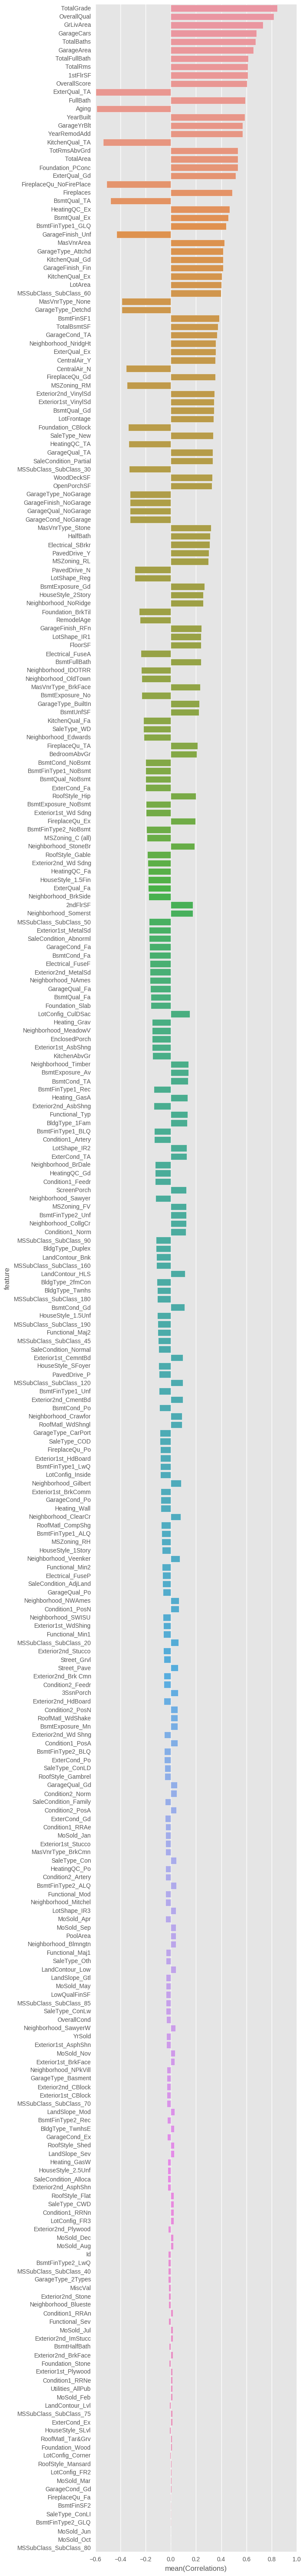

In [96]:
plot_corr(corr1)

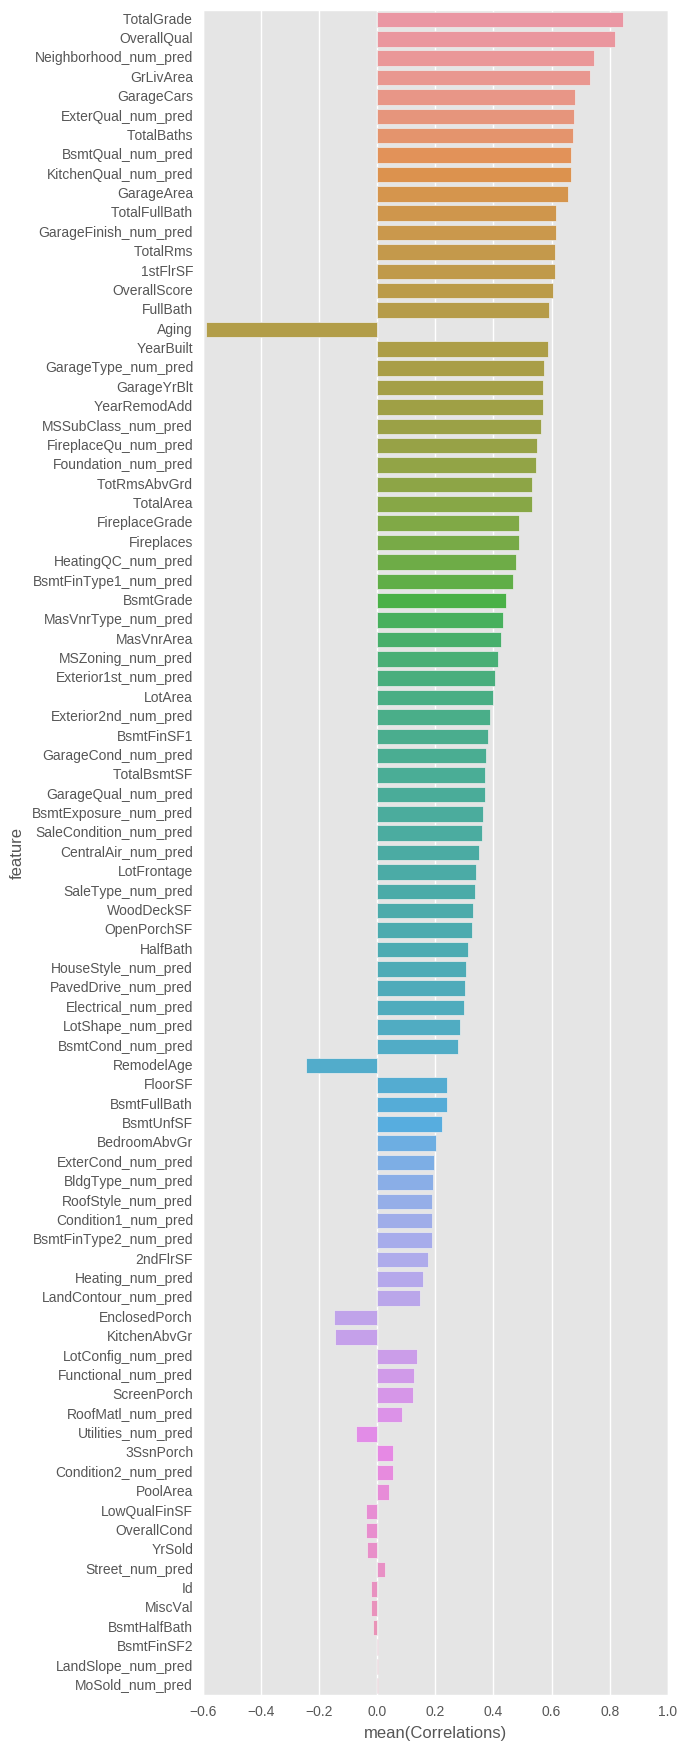

In [97]:
plot_corr(corr2)

In [98]:
cols_1 = list(corr1[:10].index)

In [99]:
def add_polynomial(data, columns):
    for feature in columns:
        data[feature+"_S2"] = data[feature] ** 2
        data[feature+"_S3"] = data[feature] ** 3
        data[feature+"_Sq"] = np.sqrt(data[feature])

In [100]:
add_polynomial(df_train_dummy,cols_1)
add_polynomial(df_test_dummy,cols_1)

In [101]:
cols_2 = list(corr2[:10].index)

In [102]:
add_polynomial(df_train_mean, cols_2)
add_polynomial(df_test_mean, cols_2)

In [103]:
DerivedHot = modified + "OneHotDerived2.pkl"
OneHot = {"train": df_train_dummy, "test": df_test_dummy}
with open(DerivedHot, 'wb') as f:
    pickle.dump(OneHot, f, pickle.HIGHEST_PROTOCOL)

In [104]:
DerivedBaysian = modified + "BayesianDerived2.pkl"
Bayesian = {"train": df_train_mean, "test": df_test_mean}
with open(DerivedBaysian, 'wb') as f:
    pickle.dump(Bayesian, f, pickle.HIGHEST_PROTOCOL)